## From Scratch Simple CNN without RESET and with Frames

AI/ CNN HW helped us generate this code - we used similar code for each frame based CNN


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/DS340/frames.zip -d /content/

Archive:  /content/drive/MyDrive/DS340/frames.zip
   creating: /content/frames/
  inflating: /content/__MACOSX/._frames  
  inflating: /content/frames/.DS_Store  
  inflating: /content/__MACOSX/frames/._.DS_Store  
   creating: /content/frames/test/
  inflating: /content/__MACOSX/frames/._test  
   creating: /content/frames/original_frames/
  inflating: /content/__MACOSX/frames/._original_frames  
   creating: /content/frames/train/
  inflating: /content/__MACOSX/frames/._train  
   creating: /content/frames/validation/
  inflating: /content/__MACOSX/frames/._validation  
   creating: /content/frames/test/TongueOut/
  inflating: /content/__MACOSX/frames/test/._TongueOut  
   creating: /content/frames/test/HandsUp/
  inflating: /content/__MACOSX/frames/test/._HandsUp  
   creating: /content/frames/test/Cry/
  inflating: /content/__MACOSX/frames/test/._Cry  
   creating: /content/frames/test/Still/
  inflating: /content/__MACOSX/frames/test/._Still  
   creating: /content/frames/test/Yaw

In [5]:
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

print("PyTorch version:", torch.__version__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

PyTorch version: 2.9.0+cu126
Using device: cuda


In [6]:
from pathlib import Path

DATA_DIR = Path("/content/frames")

print("Root frames folder:", DATA_DIR)
print("Subfolders:", list(p.name for p in DATA_DIR.iterdir()))
print("Train classes:", os.listdir(DATA_DIR / "train"))
print("Val classes:", os.listdir(DATA_DIR / "validation"))
print("Test classes:", os.listdir(DATA_DIR / "test"))

Root frames folder: /content/frames
Subfolders: ['validation', 'train', 'original_frames', 'test', '.DS_Store']
Train classes: ['HandsUp', 'Cry', 'TongueOut', 'Still', 'Yawn']
Val classes: ['HandsUp', 'Cry', 'TongueOut', 'Still', 'Yawn']
Test classes: ['HandsUp', 'Cry', 'TongueOut', 'Still', 'Yawn']


In [7]:
IMG_SIZE = 224
BATCH_SIZE = 64

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


train_dataset = datasets.ImageFolder(DATA_DIR / "train", transform=train_transform)
val_dataset   = datasets.ImageFolder(DATA_DIR / "validation", transform=val_test_transform)
test_dataset  = datasets.ImageFolder(DATA_DIR / "test", transform=val_test_transform)

NUM_CLASSES = len(train_dataset.classes)
print("Classes:", train_dataset.classes)
idx_to_class = {v:k for k,v in train_dataset.class_to_idx.items()}

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Classes: ['Cry', 'HandsUp', 'Still', 'TongueOut', 'Yawn']
Train size: 596
Val size: 124
Test size: 144


In [8]:
class SimpleEmoteCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.features = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),


            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),


            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),


            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

model = SimpleEmoteCNN(num_classes=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


Using device: cuda


In [10]:
def train_one_epoch(epoch, model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100.0

    print(f"Epoch {epoch} TRAIN - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, dataloader, criterion, device, split_name="VAL"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100.0

    print(f"{split_name} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc


In [11]:
NUM_EPOCHS = 15
PATIENCE = 5

best_val_acc = 0.0
epochs_without_improvement = 0
best_model_path = "/content/best_simple_cnn_emotes.pth"

train_loss_history, train_acc_history = [], []
val_loss_history,   val_acc_history   = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        epoch, model, train_loader, optimizer, criterion, DEVICE
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, DEVICE, split_name="VAL"
    )

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model (val_acc={best_val_acc:.4f})")
    else:
        epochs_without_improvement += 1


    if epochs_without_improvement >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

print("Training finished. Best VAL accuracy:", best_val_acc)


Epoch 1 TRAIN - Loss: 1.4689, Acc: 33.39%
VAL - Loss: 1.6012, Acc: 19.35%
Saved new best model (val_acc=19.3548)
Epoch 2 TRAIN - Loss: 1.3542, Acc: 44.97%
VAL - Loss: 1.4009, Acc: 42.74%
Saved new best model (val_acc=42.7419)
Epoch 3 TRAIN - Loss: 1.2800, Acc: 50.17%
VAL - Loss: 1.5541, Acc: 38.71%
Epoch 4 TRAIN - Loss: 1.2158, Acc: 52.01%
VAL - Loss: 1.3068, Acc: 50.81%
Saved new best model (val_acc=50.8065)
Epoch 5 TRAIN - Loss: 1.1481, Acc: 60.40%
VAL - Loss: 1.4228, Acc: 29.03%
Epoch 6 TRAIN - Loss: 1.0840, Acc: 60.23%
VAL - Loss: 1.1188, Acc: 53.23%
Saved new best model (val_acc=53.2258)
Epoch 7 TRAIN - Loss: 1.0180, Acc: 68.29%
VAL - Loss: 1.8724, Acc: 24.19%
Epoch 8 TRAIN - Loss: 0.9836, Acc: 69.30%
VAL - Loss: 1.6565, Acc: 23.39%
Epoch 9 TRAIN - Loss: 0.9343, Acc: 71.48%
VAL - Loss: 2.4071, Acc: 36.29%
Epoch 10 TRAIN - Loss: 0.9278, Acc: 71.64%
VAL - Loss: 1.4240, Acc: 42.74%
Epoch 11 TRAIN - Loss: 0.8696, Acc: 72.15%
VAL - Loss: 1.3256, Acc: 41.13%
⏹️ Early stopping triggered 

In [12]:

model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE, split_name="TEST")
print(f"TEST accuracy: {test_acc:.2f}%")

TEST - Loss: 1.1129, Acc: 54.17%
Best model TEST accuracy: 54.17%


In [ ]:
drive_save_path = "/content/drive/MyDrive/DS340/best_emotes_simple.pth"
!cp /content/best_simple_cnn_emotes.pth "$drive_save_path"
print("Saved model to:", drive_save_path)

Saved model to: /content/drive/MyDrive/DS340/best_emotes_Scratch.pth


## Graphs

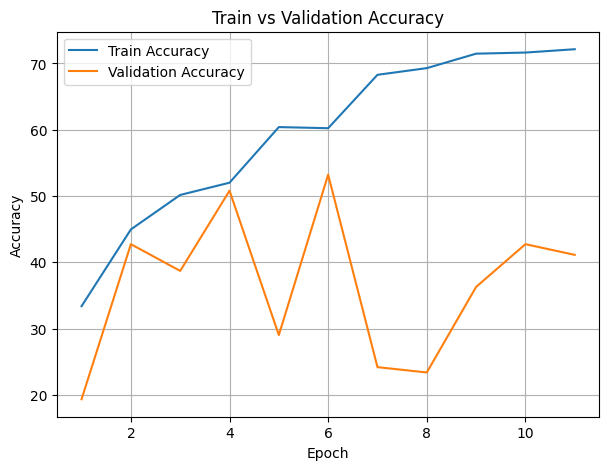

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_acc_history, label="Train Accuracy")
plt.plot(epochs, val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import numpy as np
import torch.nn.functional as F

all_labels = []
all_preds  = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

print("Labels shape:", all_labels.shape)
print("Preds shape:", all_preds.shape)

Labels shape: (144,)
Preds shape: (144,)


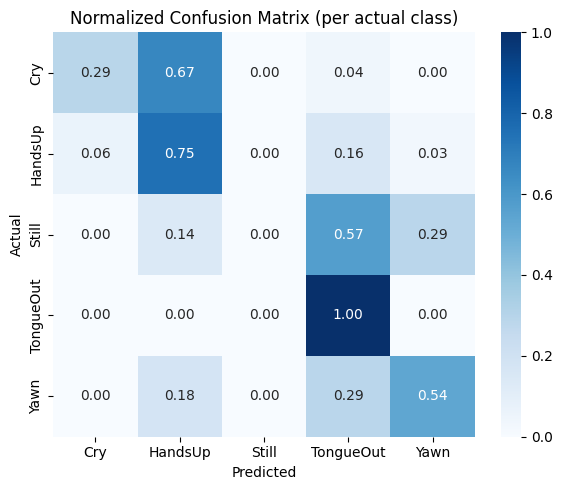

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


labels_list = list(range(NUM_CLASSES))

# Raw confusion matrix (counts)
cm = confusion_matrix(all_labels, all_preds, labels=labels_list)


cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

class_names = [idx_to_class[i] for i in labels_list]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (per actual class)")
plt.tight_layout()
plt.show()